# Load Library

In [281]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, imputation_attack, whitebox_neuron_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [74]:
experiments = { k:  MIAExperiment(name='Adult') for k in np.arange(0, 0.95, 0.05)[:1].tolist()}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

In [5]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Adult


In [6]:
experiments.keys()

dict_keys([0.0])

In [8]:
aux_df = experiments[0.0].ds.ds.df.copy()

In [275]:
mp_orig = np.array(aux_df[aux_df["is_train"]==1][['marital_Married']].value_counts().tolist())
mp_orig = mp_orig/sum(mp_orig)

In [278]:
aux_df[aux_df["is_train"]==1][['marital_Married']].value_counts()

marital_Married
False              18329
True               16893
Name: count, dtype: int64

In [276]:
mp_orig

array([0.52038499, 0.47961501])

In [318]:
married_indices = aux_df[aux_df['marital_Married']==True][aux_df["is_train"]==0][['marital_Married']].index
single_indices = aux_df[aux_df['marital_Married']==False][aux_df["is_train"]==0][['marital_Married']].index

pcnt_single = 0.52
total_count = 500
married_sample_indices = aux_df.loc[married_indices].sample(n=total_count-int(total_count * pcnt_single), replace=False).index
single_sample_indices = aux_df.loc[single_indices].sample(n=int(total_count * pcnt_single), replace=False).index

all_sample_indices = married_sample_indices.append(single_sample_indices)
aux_df_sample = aux_df.loc[all_sample_indices]

In [306]:
aux_df_sample[['marital_Married']].value_counts()

marital_Married
False              260
True               240
Name: count, dtype: int64

In [329]:
wb_perfs = []
imp_perfs = []
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    # experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf, aux_df=aux_df)['accuracy']
    experiment.imputation_results = imputation_attack(experiment, aux_df_onehot=aux_df_sample, subgroup_column='sex', aux_count=500,
    metrics=['precision', 'recall', 'accuracy', 'f1', 'gmean', 'mcc', 'fpr'])
    # wb_perfs.append(experiment.wb_neuron_results)
    imp_perfs.append(experiment.imputation_results)
    experiment.sens_val_ground_truth = experiment.X_train[[f'marital_Single']].to_numpy().ravel()
    # print(experiment)
    # print(experiment.wb_neuron_results)
    # print(experiment.imputation_results)

In [330]:
imp_perfs

[{'precision': 77.9028697571744,
  'recall': 67.16787209744956,
  'accuracy': 70.65,
  'f1': 72.13818479149633,
  'gmean': 72.8019209973538,
  'mcc': 46.221595032510656,
  'fpr': 21.091445427728615}]

In [100]:
perf_dict = {
    'Naive': {
        'precision': temp.pop(),
        'recall': temp.pop(),
        'accuracy': temp.pop(),
        'f1': temp.pop(),
        'gmean': temp.pop(),
        'mcc': temp.pop(),
        'fpr': temp.pop()
    },
    'FJRMIA': {
        'precision': temp.pop(),
        'recall': temp.pop(),
        'accuracy': temp.pop(),
        'f1': temp.pop(),
        'gmean': temp.pop(),
        'mcc': temp.pop(),
        'fpr': temp.pop()
    },
    'CSMIA': {
        'precision': temp.pop(),
        'recall': temp.pop(),
        'accuracy': temp.pop(),
        'f1': temp.pop(),
        'gmean': temp.pop(),
        'mcc': temp.pop(),
        'fpr': temp.pop()
    },
    'LOMIA': {
        'precision': temp.pop(),
        'recall': temp.pop(),
        'accuracy': temp.pop(),
        'f1': temp.pop(),
        'gmean': temp.pop(),
        'mcc': temp.pop(),
        'fpr': temp.pop()
    },
}

In [101]:
perf_dict

{'Naive': {'precision': 0.0,
  'recall': 0.0,
  'accuracy': 52.04,
  'f1': 0.0,
  'gmean': 0.0,
  'mcc': 0.0,
  'fpr': 0.0},
 'FJRMIA': {'precision': 88.11,
  'recall': 22.42,
  'accuracy': 61.34,
  'f1': 35.75,
  'gmean': 46.69,
  'mcc': 29.9,
  'fpr': 2.79},
 'CSMIA': {'precision': 86.04,
  'recall': 45.37,
  'accuracy': 70.27,
  'f1': 59.41,
  'gmean': 65.03,
  'mcc': 44.3,
  'fpr': 6.79},
 'LOMIA': {'precision': 86.35,
  'recall': 44.84,
  'accuracy': 70.14,
  'f1': 59.02,
  'gmean': 64.74,
  'mcc': 44.3,
  'fpr': 6.53}}

In [102]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from imblearn.metrics import geometric_mean_score

def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate,
    'gmean': geometric_mean_score,
    'mcc': matthews_corrcoef
}

metrics = ['precision', 'recall', 'accuracy', 'f1', 'gmean', 'mcc', 'fpr']

In [107]:
experiment.sens_val_ground_truth[:]

array([0., 1., 1., ..., 1., 1., 1.])

In [108]:
perf_dict['RandGA'] = {
    metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[:], np.random.choice([0., 1.], size=experiment.sens_val_ground_truth.shape[0])) for metric in metrics
}

In [338]:
perf_dict['ImpUBA'] = imp_perfs[0]

In [339]:
perf_df = pd.DataFrame.from_dict(perf_dict, orient='index')

In [ ]:
perf_dict

In [335]:
perf_df = perf_df.loc[['Naive', 'RandGA', 'ImpA', 'FJRMIA', 'CSMIA', 'LOMIA']]

In [337]:
perf_dict = {'Naive': {'precision': 0.0,
  'recall': 0.0,
  'accuracy': 52.04,
  'f1': 0.0,
  'gmean': 0.0,
  'mcc': 0.0,
  'fpr': 0.0},
 'RandGA': {'precision': 52.15254237288136,
  'recall': 49.506246931092804,
  'accuracy': 50.28391346317642,
  'f1': 51.3527733931489,
  'gmean': 49.87883873855966,
  'mcc': -0.22369209172280474,
  'fpr': 50.18},
#  'ImpA': {'precision': 90.9048067860509,
#   'recall': 36.71488389798249,
#   'accuracy': 64.48,
#   'f1': 52.30477223427332,
#   'gmean': 59.34799313932429,
#   'mcc': 39.873909213779484,
#   'fpr': 4.066582385166456},
 'FJRMIA': {'precision': 88.11,
  'recall': 22.42,
  'accuracy': 61.34,
  'f1': 35.75,
  'gmean': 46.69,
  'mcc': 29.9,
  'fpr': 2.79},
 'CSMIA': {'precision': 86.04,
  'recall': 45.37,
  'accuracy': 70.27,
  'f1': 59.41,
  'gmean': 65.03,
  'mcc': 44.3,
  'fpr': 6.79},
 'LOMIA': {'precision': 86.35,
  'recall': 44.84,
  'accuracy': 70.14,
  'f1': 59.02,
  'gmean': 64.74,
  'mcc': 44.3,
  'fpr': 6.53}}

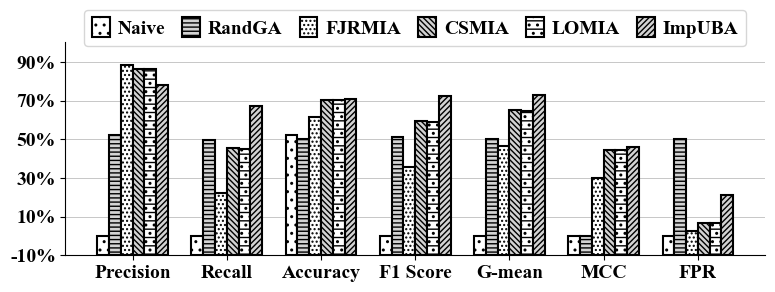

In [353]:
data = perf_df.copy()

df = pd.DataFrame(data).T

# Define hatches for each metric
# hatches = ['---...', '----', '....', '\\\\\\\\\\\\', '0..', '//////', 'o', 'O', '.', '*']
hatches = ['0..', '----', '....', '\\\\\\\\\\\\', '--..', '//////', 'o', 'O', '.', '*']
alphas = [0.1, 0.9] * 4
colors = ['#FFFFFF', '#D3D3D3']

# Plotting
mpl.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(8, 3))
plt.grid(True, linewidth=0.5, axis='y', zorder=0)
width = 0.125  # width of the bars

x = np.arange(len(df))  # label locations

# Plot each metric with different hatches
for i, metric in enumerate(df.columns):
    ax.bar(x + i * width, df[metric]+10, width, label=metric, hatch=hatches[i % len(hatches)], color=colors[i % len(colors)], edgecolor='black', linewidth=1.5, bottom=-10, zorder=2)

# Add labels, title, and legend
ax.set_ylim(-10, 100)
# ax.set_xlabel('Metrics', fontsize=14, fontweight='bold')
# ax.set_ylabel('Scores (%)', fontsize=14, fontweight='bold')
# ax.set_title('Comparison of Models across Different Metrics')
ax.set_xticks(x + width * (len(df.columns) - 1) / 2)
ax.set_xticklabels(['Precision', 'Recall', 'Accuracy', 'F1 Score', 'G-mean', 'MCC', 'FPR'], fontsize=14, fontweight='bold')
# ax.set_xticklabels(df.index, fontsize=10, fontweight='bold')
ax.set_yticks(np.arange(-10, 110, 20))
ax.set_yticklabels([f'{i:.0f}%' for i in np.arange(-10, 110, 20)], fontsize=14, fontweight='bold')
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
# ax.tick_params(axis='y', labelsize=12, weight='bold')
# plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=len(df.columns), fontsize=14, prop={'size': 14, 'weight': 'bold'}, handlelength=0.9, handleheight=1.2, columnspacing=0.9, handletextpad=0.4)

plt.tight_layout()
plt.savefig('../Adult_DT.pdf')

In [113]:
perf_df

,precision,recall,accuracy,f1,gmean,mcc,fpr
Naive,0.000000,0.000000,52.040000,0.000000,0.000000,0.000000,0.000000
FJRMIA,88.110000,22.420000,61.340000,35.750000,46.690000,29.900000,2.790000
CSMIA,86.040000,45.370000,70.270000,59.410000,65.030000,44.300000,6.790000
LOMIA,86.350000,44.840000,70.140000,59.020000,64.740000,44.300000,6.530000
RandGA,52.152542,49.506247,50.283913,51.352773,49.878839,-0.223692,50.180000
Imputation,90.904807,36.714884,64.480000,52.304772,59.347993,39.873909,4.066582


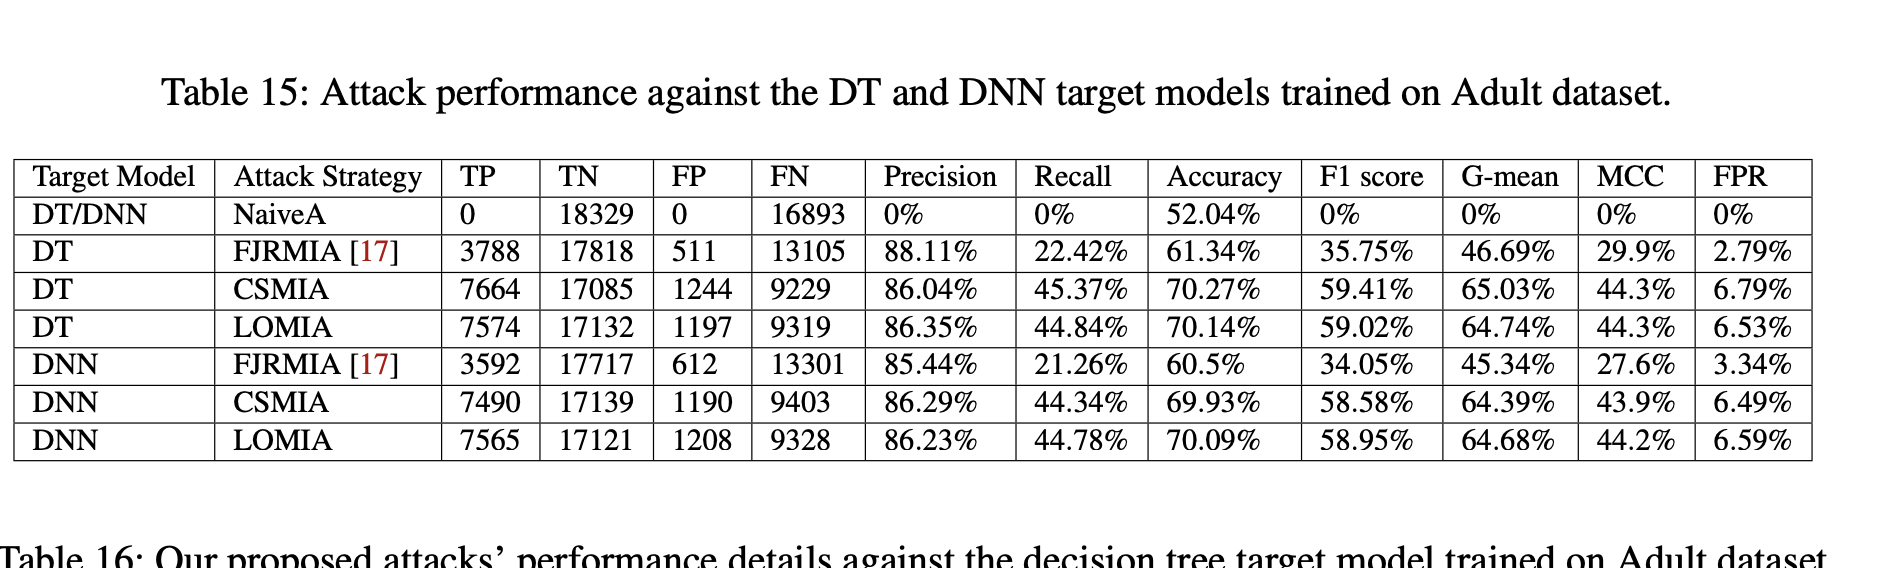

In [99]:
temp = copy.deepcopy(temp_2)

In [97]:
temp=[]
while True:
    x = input()
    x = float(x)
    if x == -1:
        break
    print(x)
    temp.append(x)

6.53
44.3
64.74
59.02
70.14
44.84
86.35
6.79
44.3
65.03
59.41
70.27
45.37
86.04
2.79
29.9
46.69
35.75
61.34
22.42
88.11
0.0
0.0
0.0
0.0
52.04
0.0
0.0


In [95]:
temp.pop()

3.0

Text(0, 0.5, 'NeurImp Attack Performance')

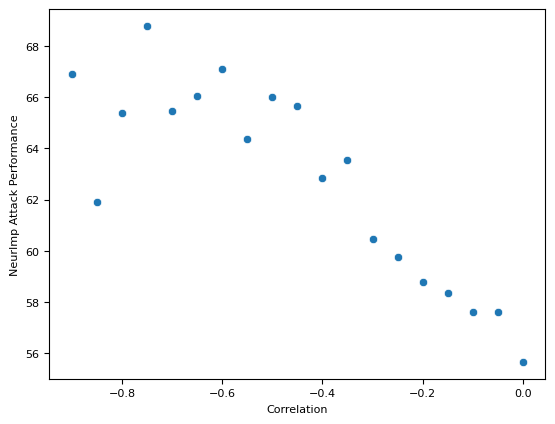

In [39]:
sns.scatterplot(x=correlations, y=wb_perfs)
plt.xlabel('Correlation')
plt.ylabel('NeurImp Attack Performance')

Text(0, 0.5, 'Imputation Attack Performance')

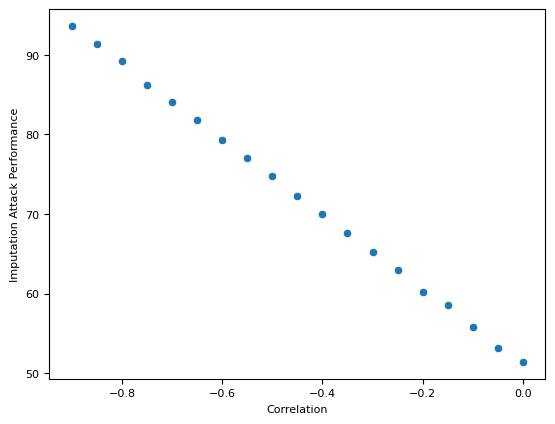

In [40]:
sns.scatterplot(x=correlations, y=imp_perfs)
plt.xlabel('Correlation')
plt.ylabel('Imputation Attack Performance')

In [31]:
experiments[f'corr_btn_sens_and_out_(-0.9, -0.9)'].wb_neuron_results

{'accuracy': 66.908,
 'precision': 66.4641271325076,
 'recall': 68.256,
 'fpr': 34.44,
 'f1': 67.34814697872677}

In [30]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment)
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf)
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [39]:
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment, subgroup_column='ETHNICITY')
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf, subgroup_column='ETHNICITY')
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [31]:
def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate
}

metrics = ['accuracy', 'precision', 'recall', 'fpr', 'f1']

In [32]:
performance_dict = {}
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [74]:
performance_dict_texas = {}
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict_texas[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict_texas[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict_texas[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [81]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

def plot_result(performance_dict, metric='accuracy'):
    attacks = ['CSMIA', 'LOMIA', 'imputation', 'wb_neuron']
    attack_names = attacks[:2] + ['Imputation', 'NeuronIMP']
    metric_name_dict = {'accuracy': 'Attack Accuracy', 'f1': 'F1 Score'}
    performance_dict_metric = {corr: {f'{attack}_results': performance_dict[corr][f'{attack}_results'][metric] for attack in attacks} for corr in performance_dict}

    df = pd.DataFrame.from_dict(performance_dict_metric, orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}_results'], label=attack_names[i], marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)

    x_ticks = np.arange(df.index.min(), df.index.max() + 0., 0.15).round(2).tolist()
    plt.xticks(x_ticks)
    plt.legend()
    plt.xlabel('Correlation')
    plt.ylabel(metric_name_dict[metric])
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    # plt.plot(df.index, df['LOMIA_attack_accuracy'], label='LOMIA', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))
    # plt.plot(df.index, df['imputation_attack_accuracy'], label='Imputation', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))

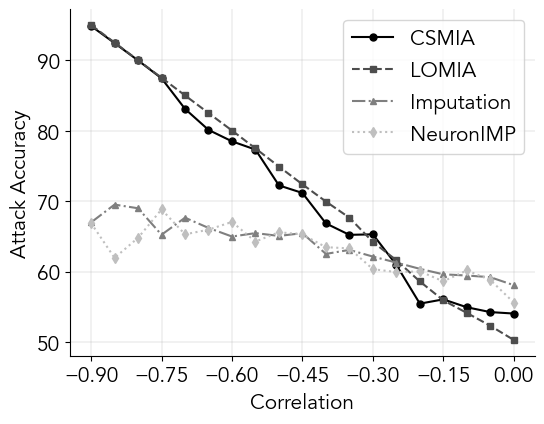

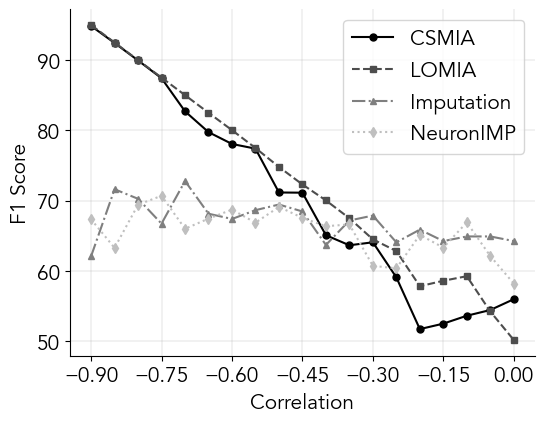

In [82]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict, metric=metric)

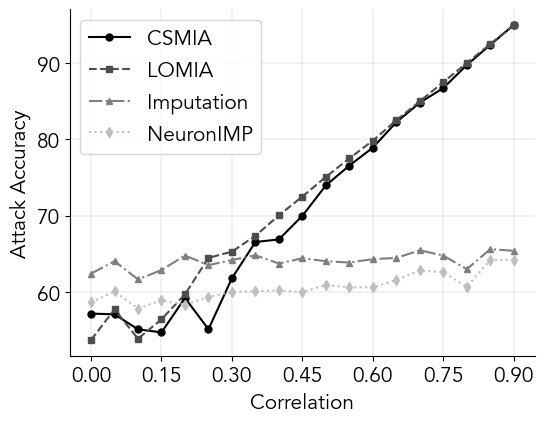

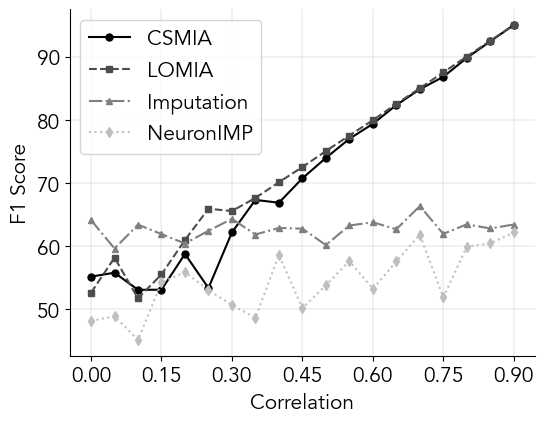

In [83]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict_texas, metric=metric)